<a href="https://colab.research.google.com/github/AntonDozhdikov/Demography_migration/blob/main/MADDPG_vs_EVO_vs_DGM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:

"Блок эксперимента с обычным MADDPG, эволюционным оптимизатором MADDPG-EVO"
"Упрощеная Дарвин-Гёдель-машина MADDPG-EVO-DGM"
# Импорт библиотек для численных вычислений и обработки данных
import numpy as np
import pandas as pd
# Импорт библиотек PyTorch для построения и обучения нейронных сетей
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
# Импорт структур данных и модуля генерации случайных чисел
from collections import defaultdict, deque
import random
# Импорт модулей для работы с JSON, построения графиков
import json
import matplotlib.pyplot as plt
# Импорт модуля для работы с датой и временем
from datetime import datetime
# Импорт модуля для управления предупреждениями
import warnings
warnings.filterwarnings('ignore')
# Настройка случайных семян для воспроизводимости экспериментальных результатов
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
# Настройка matplotlib для корректного отображения русского текста
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# --- БЛОК 1: Обработка файлов  и генерация демографических данных ---
class DemographicDataProcessor:
    """Обработчик демографических данных на основе реальных региональных данных"""
    def __init__(self, real_data_path, crisis_scenarios_path):
        """Инициализация обработчика данных"""
        self.df = pd.read_csv(real_data_path)
        # Загрузка сценариев кризисов из JSON файла
        with open(crisis_scenarios_path, 'r') as f:
            self.crisis_scenarios = json.load(f)
        self.preprocess_data()
    def preprocess_data(self):
        """Предобработка реальных данных для моделирования"""
        # Заполнение пропущенных значений
        self.df = self.df.fillna(method='ffill').fillna(method='bfill')
        # Расчет дополнительных показателей там, где они отсутствуют
        self.df.loc[self.df['natural_increase_rate'].isna(), 'natural_increase_rate'] = \
            self.df['birth_rate'] - self.df['death_rate']
        # Нормализация статистик по регионам
        self.region_stats = {}
        for region in self.df['region_name'].unique():
            region_data = self.df[self.df['region_name'] == region]
            # Вычисление статистических показателей для региона
            self.region_stats[region] = {
                'birth_rate_mean': region_data['birth_rate'].mean(),
                'birth_rate_std': region_data['birth_rate'].std(),
                'death_rate_mean': region_data['death_rate'].mean(),
                'death_rate_std': region_data['death_rate'].std(),
                'migration_mean': region_data['migration_balance'].mean(),
                'migration_std': region_data['migration_balance'].std(),
                'gdp_mean': region_data['gdp_per_capita'].mean(),
                'gdp_std': region_data['gdp_per_capita'].std(),
                'unemployment_mean': region_data['unemployment_rate'].mean(),
                'unemployment_std': region_data['unemployment_rate'].std(),
                'population_trend': self._calculate_trend(region_data['population']),
                'region_id': region_data['region_id'].iloc[0]
            }
    def _calculate_trend(self, series):
        """Расчет тренда временного ряда"""
        series = series.dropna()
        if len(series) < 2:
            return 0
        x = np.arange(len(series))
        z = np.polyfit(x, series, 1)
        return z[0]
    def apply_crisis_impact(self, base_values, crisis_scenario, year, crisis_start_year):
        """Применение воздействия кризиса на демографические показатели"""
        crisis_duration = year - crisis_start_year + 1
        max_duration = crisis_scenario['end_year'] - crisis_scenario['start_year'] + 1
        # Интенсивность кризиса убывает со временем
        intensity = max(0, 1 - (crisis_duration - 1) / max_duration)
        impacts = crisis_scenario['demographic_impacts']
        # Расчет воздействий на каждый показатель
        birth_rate_impact = impacts['birth_rate_change'] * intensity
        death_rate_impact = impacts['death_rate_change'] * intensity
        migration_impact = impacts['migration_change'] * intensity
        economic_impact = impacts['economic_impact'] * intensity
        modified_values = base_values.copy()
        # Применение воздействий к показателям
        modified_values['birth_rate'] *= (1 + birth_rate_impact)
        modified_values['death_rate'] *= (1 + death_rate_impact)
        modified_values['migration_balance'] *= (1 + migration_impact)
        modified_values['gdp_per_capita'] *= (1 + economic_impact)
        modified_values['unemployment_rate'] *= (1 - economic_impact * 0.5)
        return modified_values
    def generate_training_data(self, years, regions, apply_crisis=True):
        """Генерация данных для обучения на основе реальных данных"""
        training_data = []
        for year in years:
            for region in regions:
                if region not in self.region_stats:
                    continue
                # Получение реальных данных для региона и года, если доступны
                real_data = self.df[(self.df['region_name'] == region) & (self.df['year'] == year)]
                if len(real_data) > 0:
                    # Использование реальных данных
                    base_values = {
                        'region_id': real_data['region_id'].iloc[0],
                        'region_name': region,
                        'year': year,
                        'birth_rate': real_data['birth_rate'].iloc[0],
                        'death_rate': real_data['death_rate'].iloc[0],
                        'migration_balance': real_data['migration_balance'].iloc[0],
                        'gdp_per_capita': real_data['gdp_per_capita'].iloc[0],
                        'unemployment_rate': real_data['unemployment_rate'].iloc[0],
                        'population': real_data['population'].iloc[0],
                        'average_wage': real_data['average_wage'].iloc[0]
                    }
                else:
                    # Генерация синтетических данных на основе статистик
                    stats = self.region_stats[region]
                    base_values = {
                        'region_id': stats['region_id'],
                        'region_name': region,
                        'year': year,
                        'birth_rate': max(0, np.random.normal(stats['birth_rate_mean'], stats['birth_rate_std'])),
                        'death_rate': max(0, np.random.normal(stats['death_rate_mean'], stats['death_rate_std'])),
                        'migration_balance': np.random.normal(stats['migration_mean'], stats['migration_std']),
                        'gdp_per_capita': max(0, np.random.normal(stats['gdp_mean'], stats['gdp_std'])),
                        'unemployment_rate': max(0, min(100, np.random.normal(stats['unemployment_mean'], stats['unemployment_std'])))
                    }
                # Применение кризисных сценариев при необходимости
                if apply_crisis:
                    for scenario in self.crisis_scenarios:
                        if scenario['start_year'] <= year <= scenario['end_year']:
                            base_values = self.apply_crisis_impact(
                                base_values, scenario, year, scenario['start_year']
                            )
                # Расчет производных показателей
                base_values['natural_increase_rate'] = base_values['birth_rate'] - base_values['death_rate']
                # Расчет населения с учетом тренда
                if 'population' not in base_values:
                    base_population = 1000000 + stats['population_trend'] * (year - 2010)
                    base_values['population'] = max(0, int(base_population +
                        (base_values['natural_increase_rate'] + base_values['migration_balance']/1000) * 1000))
                # Расчет средней заработной платы
                if 'average_wage' not in base_values or pd.isna(base_values['average_wage']):
                    base_values['average_wage'] = max(0, base_values['gdp_per_capita'] * 0.03 *
                        (1 - base_values['unemployment_rate']/100))
                training_data.append(base_values)
        return pd.DataFrame(training_data)


In [14]:
# --- БЛОК 2: Определение среды обучения (DemographicEnvironment) ---
class DemographicEnvironment:
    """Многоагентная среда для демографического моделирования"""
    def __init__(self, data, n_regions=8, max_steps=50):
        self.data = data
        # Получение первых n_regions уникальных названий регионов
        self.regions = data['region_name'].unique()[:n_regions]
        self.n_regions = len(self.regions)
        self.max_steps = max_steps
        self.current_step = 0
        # Размерности пространств состояний и действий
        self.state_dim = 8  # основные демографические показатели
        self.action_dim = 4  # действия политики
        # История стабильности для каждого региона (используется в улучшенной метрике)
        self.stability_history = {region: deque(maxlen=20) for region in self.regions}
        self.reset()
    def reset(self):
        """Сброс среды к начальному состоянию"""
        self.current_step = 0
        self.states = {}
        self.histories = {region: [] for region in self.regions}
        # Инициализация состояний всех регионов
        for i, region in enumerate(self.regions):
            region_data = self.data[self.data['region_name'] == region].iloc[0]
            self.states[region] = self._normalize_state(region_data)
        return self.get_observations()
    def _normalize_state(self, region_data):
        """Нормализация состояния региона"""
        return np.array([
            region_data['birth_rate'] / 20.0,  # Нормализация рождаемости
            region_data['death_rate'] / 30.0,  # Нормализация смертности
            region_data['natural_increase_rate'] / 10.0,  # Нормализация естественного прироста
            min(region_data['migration_balance'] / 100000.0, 1.0),  # Нормализация миграции
            region_data['gdp_per_capita'] / 2000000.0,  # Нормализация ВВП на душу населения
            region_data['unemployment_rate'] / 100.0,  # Нормализация безработицы
            region_data['population'] / 10000000.0,  # Нормализация населения
            region_data['average_wage'] / 200000.0  # Нормализация средней зарплаты
        ])
    def get_observations(self):
        """Получение наблюдений для всех агентов"""
        observations = {}
        for region in self.regions:
            # Локальное наблюдение (состояние текущего региона)
            obs = self.states[region].copy()
            # Сбор состояний других регионов
            other_states = [self.states[r] for r in self.regions if r != region]
            # Добавление усредненной информации о других регионах
            if other_states:
                avg_other = np.mean(other_states, axis=0)
                obs = np.concatenate([obs, avg_other])
            else:
                obs = np.concatenate([obs, np.zeros(self.state_dim)])
            observations[region] = obs
        return observations
    def step(self, actions):
        """Выполнение шага в среде"""
        rewards = {}
        for region in self.regions:
            if region in actions:
                action = actions[region]
                old_state = self.states[region].copy()
                # Обновление состояния региона на основе действия
                self.states[region] = self._apply_policy_action(self.states[region], action)
                # Расчет награды за переход от старого состояния к новому
                rewards[region] = self._calculate_reward(old_state, self.states[region])
                # Сохранение истории шагов
                self.histories[region].append({
                    'step': self.current_step,
                    'state': old_state.copy(),
                    'action': action.copy(),
                    'reward': rewards[region]
                })
        self.current_step += 1
        done = self.current_step >= self.max_steps
        return self.get_observations(), rewards, done, {}
    def _apply_policy_action(self, state, action):
        """Применение действий политики к состоянию региона"""
        new_state = state.copy()
        # action[0] - материнский капитал (влияет на рождаемость)
        # action[1] - здравоохранение (влияет на смертность)
        # action[2] - миграционная политика (влияет на миграцию)
        # action[3] - экономические стимулы (влияет на ВВП и безработицу)
        birth_rate_change = action[0] * 0.1
        death_rate_change = -action[1] * 0.05
        migration_change = action[2] * 0.05
        economic_change = action[3] * 0.02
        # Обновление показателей с учетом действий и ограничений
        new_state[0] = max(0, new_state[0] + birth_rate_change)  # рождаемость
        new_state[1] = max(0, new_state[1] + death_rate_change)  # смертность
        new_state[2] = new_state[0] - new_state[1]  # естественный прирост
        new_state[3] = new_state[3] + migration_change  # миграционный баланс
        new_state[4] = max(0, new_state[4] + economic_change)  # ВВП на душу
        new_state[5] = max(0, min(1, new_state[5] - economic_change * 0.5))  # безработица
        # Обновление численности населения
        population_change = (new_state[2] + new_state[3]) * 0.01
        new_state[6] = max(0, new_state[6] + population_change)  # население
        # Обновление средней заработной платы
        new_state[7] = new_state[4] * 0.1 * (1 - new_state[5])  # средняя зарплата
        return new_state
    def _calculate_reward(self, old_state, new_state):
        """Расчет награды на основе улучшения демографических показателей"""
        # Положительные изменения показателей (с весами)
        birth_rate_improvement = (new_state[0] - old_state[0]) * 10
        death_rate_improvement = (old_state[1] - new_state[1]) * 10
        natural_increase_improvement = (new_state[2] - old_state[2]) * 15
        migration_improvement = (new_state[3] - old_state[3]) * 5
        gdp_improvement = (new_state[4] - old_state[4]) * 5
        unemployment_improvement = (old_state[5] - new_state[5]) * 5
        # Усиленный штраф за нестабильность населения
        population_stability = -abs(new_state[6] - old_state[6]) * 5
        # Суммирование всех компонентов награды
        total_reward = (birth_rate_improvement + death_rate_improvement +
                       natural_increase_improvement + migration_improvement +
                       gdp_improvement + unemployment_improvement + population_stability)
        return total_reward


In [15]:
# --- БЛОК 3: Определение нейронных сетей для агентов ---
class ActorNetwork(nn.Module):
    """Сеть актора для MADDPG"""
    def __init__(self, input_dim, action_dim, hidden_dim=256):
        super(ActorNetwork, self).__init__()
        # Полносвязные слои
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, action_dim)
        self.dropout = nn.Dropout(0.1)
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc3(x))  # действия от -1 до 1
        return x

class CriticNetwork(nn.Module):
    """Сеть критика для MADDPG"""
    def __init__(self, state_dim, action_dim, n_agents, hidden_dim=256):
        super(CriticNetwork, self).__init__()
        # Расчет размера входа (состояния и действия всех агентов)
        total_input_dim = state_dim * n_agents + action_dim * n_agents
        self.fc1 = nn.Linear(total_input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, states, actions):
        x = torch.cat([states, actions], dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [16]:
# --- БЛОК 4: Определение агентов (MADDPG) ---
class MADDPGAgent:
    """Агент MADDPG"""
    def __init__(self, agent_id, state_dim, action_dim, n_agents, lr_actor=1e-4, lr_critic=1e-3, device=None):
        self.agent_id = agent_id
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.n_agents = n_agents
        # Добавляем поддержку устройства (device)
        self.device = device or torch.device("cpu")
        # Сети актора (основная и целевая)
        self.actor = ActorNetwork(state_dim, action_dim).to(self.device)
        self.actor_target = ActorNetwork(state_dim, action_dim).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=lr_actor)
        # Сети критика (основная и целевая)
        self.critic = CriticNetwork(state_dim, action_dim, n_agents).to(self.device)
        self.critic_target = CriticNetwork(state_dim, action_dim, n_agents).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=lr_critic)
        # Инициализация целевых сетей копированием весов из основных
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)
        # Параметры обучения
        self.gamma = 0.95  # коэффициент дисконтирования
        self.tau = 0.02    # параметр мягкого обновления
    def act(self, state, noise_scale=0.1):
        """Выбор действия с шумом для исследования"""
        # Преобразуем состояние в тензор и перемещаем на устройство
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        action = self.actor(state_tensor).cpu().squeeze(0).detach().numpy()
        # Добавление шума для исследования
        noise = np.random.normal(0, noise_scale, size=action.shape)
        action = np.clip(action + noise, -1, 1)
        return action
    def hard_update(self, target, source):
        """Жесткое обновление параметров целевой сети"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)
    def soft_update(self, target, source):
        """Мягкое обновление параметров целевой сети"""
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.tau) + param.data * self.tau)

In [17]:
# --- БЛОК 5: Эволюционный бустер (EvolutionaryBooster) ---
class EvolutionaryBooster:
    """Эволюционный бустер для оптимизации MARL агентов"""
    def __init__(self, population_size=16, mutation_rate=0.1, crossover_rate=0.7):
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.crossover_rate = crossover_rate
        self.population = []
        self.fitness_history = []
    def initialize_population(self, agent_template):
        """Инициализация популяции агентов"""
        self.population = []
        for _ in range(self.population_size):
            agent_copy = self._copy_agent(agent_template)
            self._mutate_agent(agent_copy, mutation_strength=0.3)
            self.population.append(agent_copy)
    def _copy_agent(self, agent):
        """Создание копии агента"""
        # Определяем тип агента и создаем новый экземпляр соответствующего класса
        # Передаем аргумент device при создании копии
        if isinstance(agent, MADDPGAgent):
            new_agent = MADDPGAgent(
                agent.agent_id,
                agent.state_dim,
                agent.action_dim,
                agent.n_agents,
                device=agent.device # Передаем устройство
            )
        else:
            raise ValueError(f"Неподдерживаемый тип агента: {type(agent)}")
        # Копируем состояния сетей
        if hasattr(agent, 'actor'):
            new_agent.actor.load_state_dict(agent.actor.state_dict())
            # Убедимся, что сети новой копии находятся на том же устройстве
            new_agent.actor.to(agent.device)
            new_agent.actor_target.to(agent.device)
        if hasattr(agent, 'critic'):
            new_agent.critic.load_state_dict(agent.critic.state_dict())
            new_agent.critic.to(agent.device)
            new_agent.critic_target.to(agent.device)
        if hasattr(agent, 'actor_target'):
            new_agent.actor_target.load_state_dict(agent.actor_target.state_dict())
        if hasattr(agent, 'critic_target'):
            new_agent.critic_target.load_state_dict(agent.critic_target.state_dict())
        return new_agent
    def _mutate_agent(self, agent, mutation_strength=0.1):
        """Мутация параметров агента"""
        # Мутация параметров сети актора
        if hasattr(agent, 'actor'):
            for param in agent.actor.parameters():
                if np.random.random() < self.mutation_rate:
                    noise = torch.randn_like(param) * mutation_strength
                    param.data += noise
        # Мутация параметров сети критика
        if hasattr(agent, 'critic'):
            for param in agent.critic.parameters():
                if np.random.random() < self.mutation_rate:
                    noise = torch.randn_like(param) * mutation_strength
                    param.data += noise
    def _crossover_agents(self, parent1, parent2):
        """Скрещивание двух агентов"""
        child1 = self._copy_agent(parent1)
        child2 = self._copy_agent(parent2)
        # Скрещивание параметров актора
        if hasattr(parent1, 'actor') and hasattr(parent2, 'actor'):
            for p1, p2, c1, c2 in zip(parent1.actor.parameters(), parent2.actor.parameters(),
                                     child1.actor.parameters(), child2.actor.parameters()):
                if np.random.random() < self.crossover_rate:
                    mask = torch.rand_like(p1) > 0.5
                    c1.data = torch.where(mask, p1.data, p2.data)
                    c2.data = torch.where(mask, p2.data, p1.data)
        # Скрещивание параметров критика
        if hasattr(parent1, 'critic') and hasattr(parent2, 'critic'):
            for p1, p2, c1, c2 in zip(parent1.critic.parameters(), parent2.critic.parameters(),
                                     child1.critic.parameters(), child2.critic.parameters()):
                if np.random.random() < self.crossover_rate:
                    mask = torch.rand_like(p1) > 0.5
                    c1.data = torch.where(mask, p1.data, p2.data)
                    c2.data = torch.where(mask, p2.data, p1.data)
        return child1, child2
    def evolve_population(self, fitness_scores):
        """Эволюция популяции на основе функции приспособленности"""
        # Объединение агентов и их приспособленности, сортировка по приспособленности
        population_fitness = list(zip(self.population, fitness_scores))
        population_fitness.sort(key=lambda x: x[1], reverse=True)
        # Отбор лучших особей (элита)
        elite_size = self.population_size // 4
        elite = [agent for agent, _ in population_fitness[:elite_size]]
        # Создание нового поколения
        new_population = elite.copy()
        # Заполнение популяции до требуемого размера
        while len(new_population) < self.population_size:
            parent1 = self._tournament_selection(population_fitness)
            parent2 = self._tournament_selection(population_fitness)
            if np.random.random() < self.crossover_rate:
                child1, child2 = self._crossover_agents(parent1, parent2)
                self._mutate_agent(child1)
                self._mutate_agent(child2)
                new_population.extend([child1, child2])
            else:
                child = self._copy_agent(parent1)
                self._mutate_agent(child)
                new_population.append(child)
        # Урезание популяции до требуемого размера и обновление
        self.population = new_population[:self.population_size]
        # Сохранение истории приспособленности
        self.fitness_history.append(max(fitness_scores))
        return self.population[0]  # возврат лучшего агента
    def _tournament_selection(self, population_fitness, tournament_size=3):
        """Турнирный отбор родителя"""
        tournament = random.sample(population_fitness, min(tournament_size, len(population_fitness)))
        return max(tournament, key=lambda x: x[1])[0]


In [18]:
# --- БЛОК 6: Логгер экспериментов (ExperimentLogger) ---
class ExperimentLogger:
    """Логгер для записи и визуализации результатов экспериментов"""
    def __init__(self):
        self.metrics = defaultdict(list)
        self.episode_rewards = defaultdict(list)
        self.evolution_history = []
    def log_episode(self, episode, agent_rewards, avg_reward, stability_metric):
        """Логирование результатов эпизода"""
        self.metrics['episode'].append(episode)
        self.metrics['avg_reward'].append(avg_reward)
        self.metrics['stability'].append(stability_metric)
        # Сохранение наград для каждого агента
        for agent_id, reward in agent_rewards.items():
            self.episode_rewards[agent_id].append(reward)
    def log_evolution(self, generation, best_fitness, avg_fitness):
        """Логирование результатов эволюции"""
        self.evolution_history.append({
            'generation': generation,
            'best_fitness': best_fitness,
            'avg_fitness': avg_fitness
        })
    def plot_results(self):
        """Визуализация результатов"""
        plt.figure(figsize=(15, 10))
        # График 1: Средняя награда по эпизодам
        plt.subplot(2, 3, 1)
        plt.plot(self.metrics['episode'], self.metrics['avg_reward'])
        plt.title('Средняя награда по эпизодам')
        plt.xlabel('Эпизод')
        plt.ylabel('Средняя награда')
        plt.grid(True)
        # График 2: Метрика стабильности
        plt.subplot(2, 3, 2)
        plt.plot(self.metrics['episode'], self.metrics['stability'])
        plt.title('Метрика стабильности системы')
        plt.xlabel('Эпизод')
        plt.ylabel('Стабильность')
        plt.grid(True)
        # График 3: Награды по агентам (первые 50 эпизодов)
        plt.subplot(2, 3, 3)
        for agent_id, rewards in self.episode_rewards.items():
            plt.plot(rewards[:50], label=f'Агент {agent_id}', alpha=0.7)
        plt.title('Награды агентов (первые 50 эпизодов)')
        plt.xlabel('Эпизод')
        plt.ylabel('Награда')
        plt.legend()
        plt.grid(True)
        # График 4: Эволюция популяции (если есть данные)
        if self.evolution_history:
            plt.subplot(2, 3, 4)
            generations = [x['generation'] for x in self.evolution_history]
            best_fitness = [x['best_fitness'] for x in self.evolution_history]
            avg_fitness = [x['avg_fitness'] for x in self.evolution_history]
            plt.plot(generations, best_fitness, label='Лучшая приспособленность', linewidth=2)
            plt.plot(generations, avg_fitness, label='Средняя приспособленность', alpha=0.7)
            plt.title('Эволюция популяции')
            plt.xlabel('Поколение')
            plt.ylabel('Приспособленность')
            plt.legend()
            plt.grid(True)
        # График 5: Распределение наград
        plt.subplot(2, 3, 5)
        all_rewards = []
        for rewards in self.episode_rewards.values():
            all_rewards.extend(rewards)
        plt.hist(all_rewards, bins=30, alpha=0.7, edgecolor='black')
        plt.title('Распределение наград')
        plt.xlabel('Награда')
        plt.ylabel('Частота')
        plt.grid(True)
        # График 6: Скользящее среднее наград
        plt.subplot(2, 3, 6)
        window_size = 10
        if len(self.metrics['avg_reward']) >= window_size:
            moving_avg = pd.Series(self.metrics['avg_reward']).rolling(window=window_size).mean()
            plt.plot(self.metrics['episode'], moving_avg)
            plt.title(f'Скользящее среднее наград (окно {window_size})')
            plt.xlabel('Эпизод')
            plt.ylabel('Скользящее среднее')
            plt.grid(True)
        plt.tight_layout()
        plt.show()
    def save_results(self, filename):
        """Сохранение результатов в CSV"""
        results_df = pd.DataFrame(self.metrics)
        results_df.to_csv(filename, index=False)
        print(f"Результаты сохранены в {filename}")


In [19]:
# --- БЛОК 7: Функции обучения агентов (_train_agent_*) ---
def _train_agent_maddpg(agent, replay_buffer, batch_size=32):
    """Обучение одного агента MADDPG """
    if len(replay_buffer) < batch_size:
        return
    batch = random.sample(replay_buffer, batch_size)
    # Перемещаем данные на устройство агента
    states = torch.FloatTensor([x[0] for x in batch]).to(agent.device)
    actions = torch.FloatTensor([x[1] for x in batch]).to(agent.device)
    rewards = torch.FloatTensor([x[2] for x in batch]).unsqueeze(1).to(agent.device)
    next_states = torch.FloatTensor([x[3] for x in batch]).to(agent.device)
    dones = torch.BoolTensor([x[4] for x in batch]).unsqueeze(1).to(agent.device)
    # Обновление критика
    with torch.no_grad():
        next_actions = agent.actor_target(next_states)
        # Формирование глобальных состояний и действий
        global_next_states = next_states.repeat(1, agent.n_agents).view(batch_size, -1)
        global_next_actions = next_actions.repeat(1, agent.n_agents).view(batch_size, -1)
        target_q = agent.critic_target(global_next_states, global_next_actions)
        target_q = rewards + agent.gamma * target_q * (~dones)
    global_states = states.repeat(1, agent.n_agents).view(batch_size, -1)
    global_actions = actions.repeat(1, agent.n_agents).view(batch_size, -1)
    current_q = agent.critic(global_states, global_actions)
    critic_loss = F.mse_loss(current_q, target_q)
    agent.critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
    agent.critic_optimizer.step()
    # Обновление актора
    predicted_actions = agent.actor(states)
    global_predicted_actions = predicted_actions.repeat(1, agent.n_agents).view(batch_size, -1)
    actor_loss = -agent.critic(global_states, global_predicted_actions).mean()
    agent.actor_optimizer.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 0.5)
    agent.actor_optimizer.step()
    # Мягкое обновление целевых сетей
    agent.soft_update(agent.actor_target, agent.actor)
    agent.soft_update(agent.critic_target, agent.critic)


In [20]:
# --- БЛОК 8: Вспомогательные функции оценки и метрик ---
def _evaluate_agent_fitness(agent, env, region, n_eval_episodes=3):
    """Оценка приспособленности агента"""
    total_reward = 0
    for _ in range(n_eval_episodes):
        observations = env.reset() # observations - словарь {region: obs}
        episode_reward = 0
        for _ in range(env.max_steps):
            action = agent.act(observations[region], noise_scale=0.0) # Используем шум 0.0 для оценки
            actions = {region: action}
            # Добавление случайных действий для других агентов
            for other_region in env.regions:
                if other_region != region:
                    actions[other_region] = np.random.uniform(-1, 1, env.action_dim)
            next_observations, rewards, done, _ = env.step(actions)
            episode_reward += rewards.get(region, 0)
            observations = next_observations
            if done:
                break
        total_reward += episode_reward
    return total_reward / n_eval_episodes

def _calculate_stability_metric(env):
    """Расчет улучшенной метрики стабильности демографической системы"""
    stability_scores = []
    for region in env.regions:
        state = env.states[region]
        # Расчет стабильности как среднего трех компонентов:
        # 1. Баланс рождений и смертей (штрафуем только за отрицательный прирост)
        natural_balance = max(0, -state[2]) * 2
        # 2. Экономическая стабильность (более чувствительная)
        economic_stability = 1 - (state[5] ** 2) * 1.5
        # 3. Миграционная стабильность (более строгая)
        migration_stability = 1 / (1 + abs(state[3]) * 20)
        # 4. Стабильность населения (новый компонент)
        population_stability = 1 - min(1, abs(state[6] - 1.0)) # Предполагаем нормализованное население ~1.0
        # Текущая стабильность региона
        current_stability = (natural_balance + economic_stability +
                           migration_stability + population_stability) / 4
        # Сохранение в историю
        env.stability_history[region].append(current_stability)
        # Долгосрочная стабильность (меньше колебаний = выше стабильность)
        if len(env.stability_history[region]) > 5:
            long_term_stability = 1 - np.std(env.stability_history[region]) * 2
        else:
            long_term_stability = 1.0 # Недостаточно данных для расчета
        # Финальная метрика (баланс текущей и долгосрочной стабильности)
        region_stability = 0.4 * current_stability + 0.6 * long_term_stability
        stability_scores.append(region_stability)
    return np.mean(stability_scores)


In [21]:
# --- БЛОК 9: Основные функции обучения (эксперименты) ---
# ЭКСПЕРИМЕНТ: MADDPG-EVO (улучшенный)
def train_maddpg_with_evolution(env, n_episodes=1000, min_improvement=0.1,
                               population_size=16, save_results=True, experiment_name="MADDPG-EVO"):
    """Обучение MADDPG с адаптивной эволюционной оптимизацией."""
    print(f"=== Запуск эксперимента: {experiment_name} ===")
    print(f"Обучение на {n_episodes} эпизодах. Адаптивная эволюция при замедлении прогресса (min_improvement={min_improvement}).")
    # Инициализация агентов для каждого региона
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MADDPGAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,  # локальное + глобальное состояние
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5, # Уменьшенный learning rate
            lr_critic=1e-4
        )
    # Инициализация эволюционных бустеров для каждого региона
    evolution_boosters = {}
    for region in env.regions:
        booster = EvolutionaryBooster(population_size=population_size, mutation_rate=0.05) # Уменьшена мутация
        booster.initialize_population(agents[region])
        evolution_boosters[region] = booster
    # Создание буферов памяти для каждого агента
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    # Создание логгера результатов
    logger = ExperimentLogger()
    print(f"Начало обучения на {n_episodes} эпизодах...")
    # Переменные для отслеживания прогресса и адаптивной эволюции
    reward_history = []
    last_evolution_episode = 0
    min_episodes_between_evolutions = 20 # Увеличен интервал между эволюциями
    # Основной цикл обучения по эпизодам
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        # Адаптивный шум для более точного исследования
        noise_scale = max(0.05, 0.2 * (1 - episode / n_episodes))
        # Цикл шагов внутри эпизода
        for step in range(env.max_steps):
            # Выбор действий для всех агентов
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=noise_scale)
                actions[region] = action
            # Выполнение шага в среде
            next_observations, rewards, done, _ = env.step(actions)
            # Сохранение опыта в буферы памяти
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done:
                break
        # Обучение агентов (каждые 10 эпизодов, начиная с 10-го)
        if episode % 10 == 0 and episode > 0:
            for region in env.regions:
                if len(replay_buffers[region]) > 200:
                    _train_agent_maddpg(agents[region], replay_buffers[region], batch_size=64)
        # Логирование результатов эпизода
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        # Сохраняем историю наград для анализа прогресса
        reward_history.append(avg_reward)
        # Адаптивная эволюционная оптимизация
        # Проверяем, прошло ли достаточно эпизодов с последней эволюции
        if len(reward_history) > 30 and episode - last_evolution_episode >= min_episodes_between_evolutions:
            # Рассчитываем среднее улучшение за последние 30 эпизодов
            recent_rewards = reward_history[-30:]
            improvement_rate = (recent_rewards[-1] - recent_rewards[0]) / 30
            # Если улучшение меньше порога, запускаем эволюцию
            if improvement_rate < min_improvement:
                print(f"{experiment_name} - Адаптивная эволюционная оптимизация на эпизоде {episode} (замедление прогресса)")
                for region in env.regions:
                    # Оценка приспособленности всей популяции
                    fitness_scores = []
                    for agent in evolution_boosters[region].population:
                        fitness = _evaluate_agent_fitness(agent, env, region)
                        fitness_scores.append(fitness)
                    # Эволюция популяции
                    best_agent = evolution_boosters[region].evolve_population(fitness_scores)
                    agents[region] = best_agent
                    # Логирование результатов эволюции
                    logger.log_evolution(
                        episode,
                        max(fitness_scores),
                        np.mean(fitness_scores)
                    )
                last_evolution_episode = episode # Обновляем счетчик последней эволюции
        # Вывод прогресса (каждые 20 эпизодов)
        if episode % 20 == 0:
            print(f"{experiment_name} - Эпизод {episode}, средняя награда: {avg_reward:.3f}, "
                  f"стабильность: {stability_metric:.3f}")
    print(f"{experiment_name} - Обучение завершено!")
    # Визуализация и сохранение результатов
    logger.plot_results()
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger


In [22]:
# === БЛОК 10: Обычный MADDPG (Baseline) ===
def train_maddpg_baseline(env, n_episodes=1000, save_results=True, experiment_name="MADDPG-BASELINE"):
    """Обучение обычного MADDPG без эволюционных компонентов."""
    print(f"=== Запуск эксперимента: {experiment_name} ===")
    print(f"Обучение на {n_episodes} эпизодах. Обычный MADDPG (без эволюции).")

    # Инициализация агентов для каждого региона
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MADDPGAgent(
            agent_id=i,
            state_dim=env.state_dim * 2,  # локальное + глобальное состояние
            action_dim=env.action_dim,
            n_agents=env.n_regions,
            lr_actor=5e-5, # Скорость обучения актора
            lr_critic=1e-4 # Скорость обучения критика
        )

    # Создание буферов памяти для каждого агента
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}

    # Создание логгера результатов
    logger = ExperimentLogger()

    print(f"Начало обучения на {n_episodes} эпизодах...")

    # Основной цикл обучения по эпизодам
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}

        # Адаптивный шум для исследования
        noise_scale = max(0.05, 0.3 * (1 - episode / n_episodes)) # Начальный шум немного выше

        # Цикл шагов внутри эпизода
        for step in range(env.max_steps):
            # Выбор действий для всех агентов
            actions = {}
            for region in env.regions:
                action = agents[region].act(observations[region], noise_scale=noise_scale)
                actions[region] = action

            # Выполнение шага в среде
            next_observations, rewards, done, _ = env.step(actions)

            # Сохранение опыта в буферы памяти
            for region in env.regions:
                replay_buffers[region].append((
                    observations[region], actions[region], rewards[region],
                    next_observations[region], done
                ))
                episode_rewards[region] += rewards[region]

            observations = next_observations
            if done:
                break

        # Обучение агентов (каждые 5 эпизодов, начиная с 5-го)
        if episode % 5 == 0 and episode > 5:
            for region in env.regions:
                if len(replay_buffers[region]) > 200: # Минимальный размер буфера
                    _train_agent_maddpg(agents[region], replay_buffers[region], batch_size=64)

        # Логирование результатов эпизода
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)

        # Вывод прогресса (каждые 50 эпизодов)
        if episode % 50 == 0:
            print(f"{experiment_name} - Эпизод {episode}, средняя награда: {avg_reward:.3f}, "
                  f"стабильность: {stability_metric:.3f}")

    print(f"{experiment_name} - Обучение завершено!")

    # Визуализация и сохранение результатов
    logger.plot_results()
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")

    return agents, logger


In [23]:
# === БЛОК 11: Основная функция обучения (MADDPG-EVO-DGM) ===
def train_maddpg_with_evolution_dgm(env, n_episodes=1000, min_improvement=0.1,
                               initial_population_size=16, save_results=True, experiment_name="MADDPG-EVO-DGM"):
    print(f"=== Запуск эксперимента: {experiment_name} ===")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Используемое устройство: {device}")
    agents = {}
    for i, region in enumerate(env.regions):
        agents[region] = MADDPGAgent(i, env.state_dim * 2, env.action_dim, env.n_regions, lr_actor=5e-5, lr_critic=1e-4, device=device)
    evolution_boosters = {}
    for region in env.regions:
        booster = EvolutionaryBoosterDGM(population_size=initial_population_size, initial_mutation_rate=0.05, initial_crossover_rate=0.7)
        booster.initialize_population(agents[region])
        for pop_agent in booster.population:
             pop_agent.actor.to(device); pop_agent.actor_target.to(device)
             pop_agent.critic.to(device); pop_agent.critic_target.to(device)
        evolution_boosters[region] = booster
    replay_buffers = {region: deque(maxlen=10000) for region in env.regions}
    logger = ExperimentLogger()
    print(f"Начало обучения на {n_episodes} эпизодах...")
    reward_history, stability_history = [], []
    last_evolution_episode, min_episodes_between_evolutions = 0, 15
    for episode in range(n_episodes):
        observations = env.reset()
        episode_rewards = {region: 0 for region in env.regions}
        noise_scale = max(0.05, 0.2 * (1 - episode / n_episodes))
        for step in range(env.max_steps):
            actions = {}
            for region in env.regions:
                actions[region] = agents[region].act(observations[region], noise_scale=noise_scale)
            next_observations, rewards, done, _ = env.step(actions)
            for region in env.regions:
                replay_buffers[region].append((observations[region], actions[region], rewards[region], next_observations[region], done))
                episode_rewards[region] += rewards[region]
            observations = next_observations
            if done: break
        if episode % 5 == 0 and episode > 5:
            for region in env.regions:
                if len(replay_buffers[region]) > 500:
                    _train_agent_maddpg_dgm(agents[region], replay_buffers[region], batch_size=128)
        avg_reward = np.mean(list(episode_rewards.values()))
        stability_metric = _calculate_stability_metric(env)
        logger.log_episode(episode, episode_rewards, avg_reward, stability_metric)
        reward_history.append(avg_reward)
        stability_history.append(stability_metric)
        if len(reward_history) > 20 and episode - last_evolution_episode >= min_episodes_between_evolutions:
            recent_window = min(25, len(reward_history))
            recent_rewards = reward_history[-recent_window:]
            improvement_rate = (recent_rewards[-1] - recent_rewards[0]) / recent_window
            if improvement_rate < min_improvement:
                print(f"{experiment_name} - Адаптивная эволюционная оптимизация на эпизоде {episode} (замедление прогресса)")
                other_agents_snapshot = {r: a for r, a in agents.items() if r in env.regions}
                for region in env.regions:
                    fitness_scores = []
                    for agent in evolution_boosters[region].population:
                        fitness = _evaluate_agent_fitness_improved(agent, env, region, other_agents_snapshot, n_eval_episodes=5)
                        fitness_scores.append(fitness)
                    current_avg_fitness = np.mean(fitness_scores)
                    evolution_boosters[region].adapt_parameters(current_avg_fitness)
                    best_agent = evolution_boosters[region].evolve_population(fitness_scores)
                    best_agent.actor.to(device); best_agent.actor_target.to(device)
                    best_agent.critic.to(device); best_agent.critic_target.to(device)
                    agents[region] = best_agent
                    logger.log_evolution(episode, max(fitness_scores), current_avg_fitness)
                last_evolution_episode = episode
        if episode % 20 == 0:
            print(f"{experiment_name} - Эпизод {episode}, средняя награда: {avg_reward:.3f}, стабильность: {stability_metric:.3f}")
    print(f"{experiment_name} - Обучение завершено!")
    logger.plot_results()
    if save_results:
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        logger.save_results(f"{experiment_name.lower()}_results_{timestamp}.csv")
    return agents, logger

# --- Вспомогательные функции для MADDPG-EVO-DGM  ---
class EvolutionaryBoosterDGM:
    def __init__(self, population_size=16, initial_mutation_rate=0.1, initial_crossover_rate=0.7):
        self.population_size = population_size
        self.mutation_rate = initial_mutation_rate
        self.crossover_rate = initial_crossover_rate
        self.population = []
        self.fitness_history = []
        self.last_fitness_improvement = -np.inf
        self.generations_since_improvement = 0
    def initialize_population(self, agent_template):
        self.population = []
        for _ in range(self.population_size):
            agent_copy = self._copy_agent(agent_template)
            self._mutate_agent(agent_copy, mutation_strength=0.3)
            self.population.append(agent_copy)
    def _copy_agent(self, agent):
        new_agent = MADDPGAgent(agent.agent_id, agent.state_dim, agent.action_dim, agent.n_agents, device=agent.device)
        if hasattr(agent, 'actor'): new_agent.actor.load_state_dict(agent.actor.state_dict())
        if hasattr(agent, 'critic'): new_agent.critic.load_state_dict(agent.critic.state_dict())
        if hasattr(agent, 'actor_target'): new_agent.actor_target.load_state_dict(agent.actor_target.state_dict())
        if hasattr(agent, 'critic_target'): new_agent.critic_target.load_state_dict(agent.critic_target.state_dict())
        return new_agent
    def _mutate_agent(self, agent, mutation_strength=0.1):
        if hasattr(agent, 'actor'):
            for param in agent.actor.parameters():
                if np.random.random() < self.mutation_rate:
                    noise = torch.randn_like(param) * mutation_strength
                    param.data.add_(noise)
        if hasattr(agent, 'critic'):
            for param in agent.critic.parameters():
                if np.random.random() < self.mutation_rate:
                    noise = torch.randn_like(param) * mutation_strength
                    param.data.add_(noise)
    def _crossover_agents(self, parent1, parent2):
        child1, child2 = self._copy_agent(parent1), self._copy_agent(parent2)
        if hasattr(parent1, 'actor') and hasattr(parent2, 'actor'):
            for p1, p2, c1, c2 in zip(parent1.actor.parameters(), parent2.actor.parameters(), child1.actor.parameters(), child2.actor.parameters()):
                if np.random.random() < self.crossover_rate:
                    mask = torch.rand_like(p1) > 0.5
                    c1.data.copy_(torch.where(mask, p1.data, p2.data))
                    c2.data.copy_(torch.where(mask, p2.data, p1.data))
        if hasattr(parent1, 'critic') and hasattr(parent2, 'critic'):
            for p1, p2, c1, c2 in zip(parent1.critic.parameters(), parent2.critic.parameters(), child1.critic.parameters(), child2.critic.parameters()):
                if np.random.random() < self.crossover_rate:
                    mask = torch.rand_like(p1) > 0.5
                    c1.data.copy_(torch.where(mask, p1.data, p2.data))
                    c2.data.copy_(torch.where(mask, p2.data, p1.data))
        return child1, child2
    def adapt_parameters(self, current_fitness, fitness_threshold=0.01):
        improvement = current_fitness - self.last_fitness_improvement
        if improvement < fitness_threshold:
            self.generations_since_improvement += 1
            self.mutation_rate = min(0.5, self.mutation_rate * 1.1)
            self.crossover_rate = max(0.3, self.crossover_rate * 0.95)
        else:
            self.generations_since_improvement = max(0, self.generations_since_improvement - 1)
            self.mutation_rate = max(0.01, self.mutation_rate * 0.95)
            self.crossover_rate = min(0.9, self.crossover_rate * 1.02)
        self.last_fitness_improvement = current_fitness
    def evolve_population(self, fitness_scores):
        population_fitness = list(zip(self.population, fitness_scores))
        population_fitness.sort(key=lambda x: x[1], reverse=True)
        elite_size = self.population_size // 4
        elite = [agent for agent, _ in population_fitness[:elite_size]]
        new_population = elite.copy()
        while len(new_population) < self.population_size:
            parent1 = self._tournament_selection(population_fitness)
            parent2 = self._tournament_selection(population_fitness)
            if np.random.random() < self.crossover_rate:
                child1, child2 = self._crossover_agents(parent1, parent2)
                self._mutate_agent(child1); self._mutate_agent(child2)
                new_population.extend([child1, child2])
            else:
                child = self._copy_agent(parent1)
                self._mutate_agent(child)
                new_population.append(child)
        self.population = new_population[:self.population_size]
        self.fitness_history.append(max(fitness_scores))
        return self.population[0]
    def _tournament_selection(self, population_fitness, tournament_size=3):
        tournament = random.sample(population_fitness, min(tournament_size, len(population_fitness)))
        return max(tournament, key=lambda x: x[1])[0]

def _train_agent_maddpg_dgm(agent, replay_buffer, batch_size=32):
    if len(replay_buffer) < batch_size: return
    batch = random.sample(replay_buffer, batch_size)
    states = torch.FloatTensor([x[0] for x in batch]).to(agent.device)
    actions = torch.FloatTensor([x[1] for x in batch]).to(agent.device)
    rewards = torch.FloatTensor([x[2] for x in batch]).unsqueeze(1).to(agent.device)
    next_states = torch.FloatTensor([x[3] for x in batch]).to(agent.device)
    dones = torch.BoolTensor([x[4] for x in batch]).unsqueeze(1).to(agent.device)
    with torch.no_grad():
        next_actions = agent.actor_target(next_states)
        global_next_states = next_states.repeat(1, agent.n_agents).view(batch_size, -1)
        global_next_actions = next_actions.repeat(1, agent.n_agents).view(batch_size, -1)
        target_q = agent.critic_target(global_next_states, global_next_actions)
        target_q = rewards + agent.gamma * target_q * (~dones)
    global_states = states.repeat(1, agent.n_agents).view(batch_size, -1)
    global_actions = actions.repeat(1, agent.n_agents).view(batch_size, -1)
    current_q = agent.critic(global_states, global_actions)
    critic_loss = F.mse_loss(current_q, target_q)
    agent.critic_optimizer.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.critic.parameters(), 0.5)
    agent.critic_optimizer.step()
    predicted_actions = agent.actor(states)
    global_predicted_actions = predicted_actions.repeat(1, agent.n_agents).view(batch_size, -1)
    actor_loss = -agent.critic(global_states, global_predicted_actions).mean()
    agent.actor_optimizer.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(agent.actor.parameters(), 0.5)
    agent.actor_optimizer.step()
    agent.soft_update(agent.actor_target, agent.actor)
    agent.soft_update(agent.critic_target, agent.critic)

def _evaluate_agent_fitness_improved(agent, env, region, other_agents_dict, n_eval_episodes=5):
    total_reward = 0
    for _ in range(n_eval_episodes):
        observations = env.reset()
        episode_reward = 0
        for _ in range(env.max_steps):
            state_tensor = torch.FloatTensor(observations[region]).unsqueeze(0).to(agent.device)
            with torch.no_grad():
                action = agent.actor(state_tensor).cpu().numpy().squeeze(0)
            actions = {region: np.clip(action, -1, 1)}
            for other_region, other_agent in other_agents_dict.items():
                if other_region != region:
                    other_state_tensor = torch.FloatTensor(observations[other_region]).unsqueeze(0).to(agent.device)
                    with torch.no_grad():
                        other_action = other_agent.actor(other_state_tensor).cpu().numpy().squeeze(0)
                    actions[other_region] = np.clip(other_action, -1, 1)
            next_observations, rewards, done, _ = env.step(actions)
            episode_reward += rewards.get(region, 0)
            observations = next_observations
            if done: break
        total_reward += episode_reward
    return total_reward / n_eval_episodes


=== НАЧАЛО ЭКСПЕРИМЕНТОВ ===
Загрузка и обработка реальных данных...
Обработано 200 записей для 8 регионов

--- ЭКСПЕРИМЕНТ 1: MADDPG-BASELINE ---
=== Запуск эксперимента: MADDPG-BASELINE ===
Обучение на 1000 эпизодах. Обычный MADDPG (без эволюции).
Начало обучения на 1000 эпизодах...
MADDPG-BASELINE - Эпизод 0, средняя награда: 69.251, стабильность: 1.118
MADDPG-BASELINE - Эпизод 50, средняя награда: 71.158, стабильность: 0.995
MADDPG-BASELINE - Эпизод 100, средняя награда: 78.126, стабильность: 0.942
MADDPG-BASELINE - Эпизод 150, средняя награда: 88.818, стабильность: 0.862
MADDPG-BASELINE - Эпизод 200, средняя награда: 108.392, стабильность: 0.751
MADDPG-BASELINE - Эпизод 250, средняя награда: 117.017, стабильность: 0.752
MADDPG-BASELINE - Эпизод 300, средняя награда: 138.903, стабильность: 0.719
MADDPG-BASELINE - Эпизод 350, средняя награда: 155.203, стабильность: 0.746
MADDPG-BASELINE - Эпизод 400, средняя награда: 173.259, стабильность: 0.761
MADDPG-BASELINE - Эпизод 450, средняя

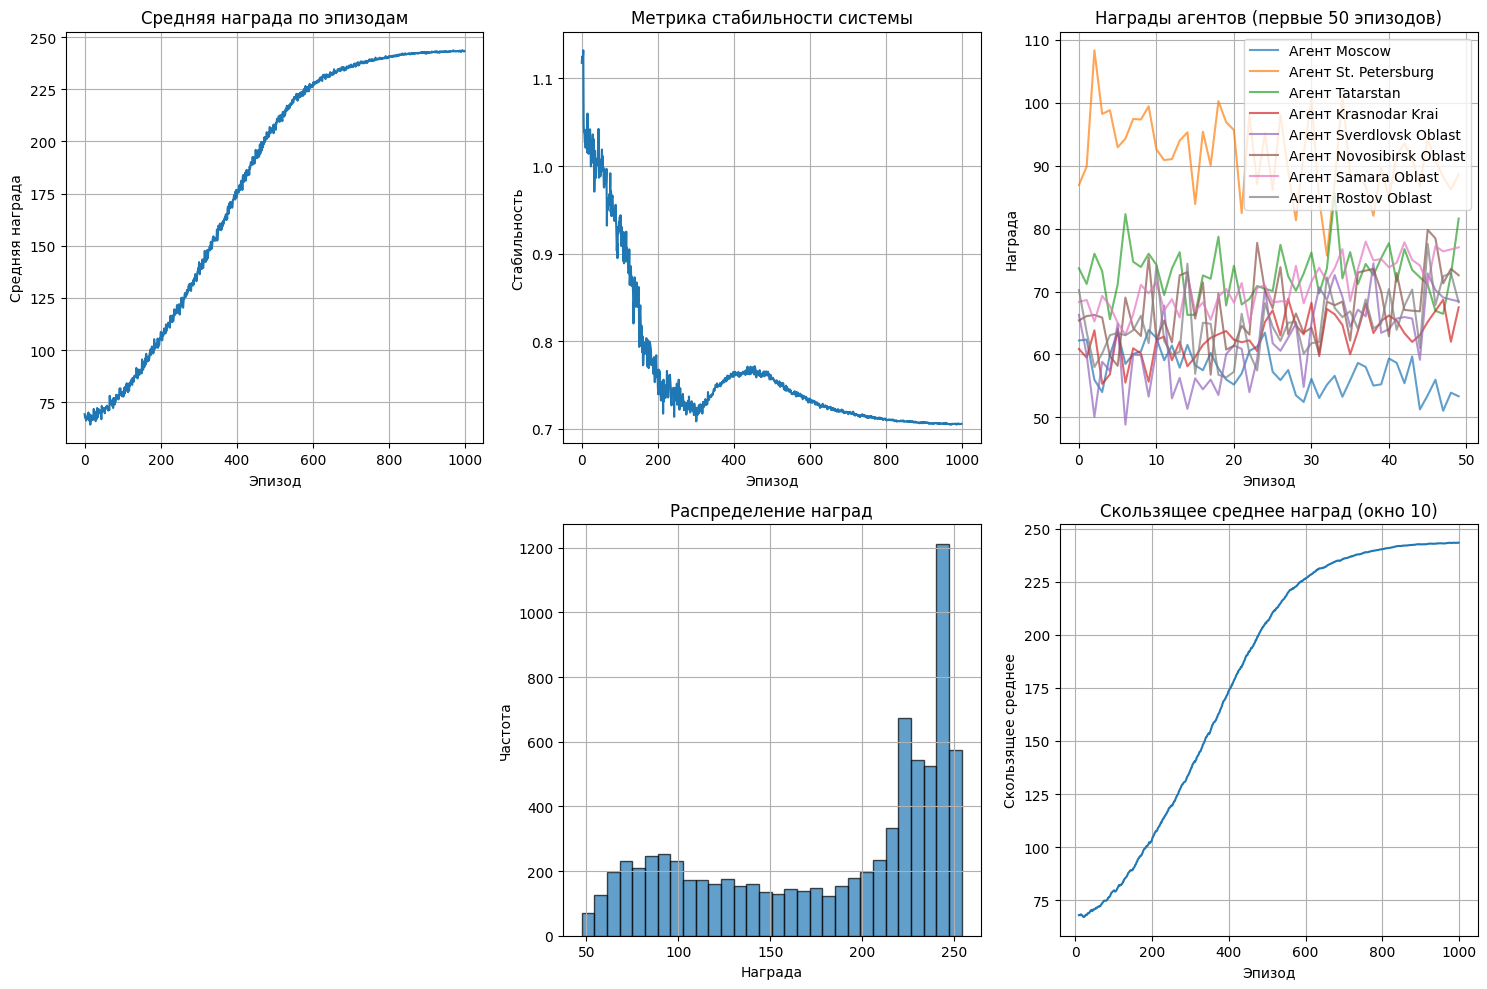

Результаты сохранены в maddpg-baseline_results_20250911_104456.csv
=== Эксперимент MADDPG-BASELINE завершен ===

--- ЭКСПЕРИМЕНТ 2: MADDPG-EVO ---
=== Запуск эксперимента: MADDPG-EVO ===
Обучение на 1000 эпизодах. Адаптивная эволюция при замедлении прогресса (min_improvement=0.1).
Начало обучения на 1000 эпизодах...
MADDPG-EVO - Эпизод 0, средняя награда: 69.970, стабильность: 1.115
MADDPG-EVO - Эпизод 20, средняя награда: 69.670, стабильность: 1.039
MADDPG-EVO - Адаптивная эволюционная оптимизация на эпизоде 30 (замедление прогресса)
MADDPG-EVO - Эпизод 40, средняя награда: 113.524, стабильность: 0.493
MADDPG-EVO - Адаптивная эволюционная оптимизация на эпизоде 60 (замедление прогресса)
MADDPG-EVO - Эпизод 60, средняя награда: 116.585, стабильность: 0.831
MADDPG-EVO - Эпизод 80, средняя награда: 121.687, стабильность: 0.802
MADDPG-EVO - Адаптивная эволюционная оптимизация на эпизоде 82 (замедление прогресса)
MADDPG-EVO - Эпизод 100, средняя награда: 156.254, стабильность: 0.763
MADDPG

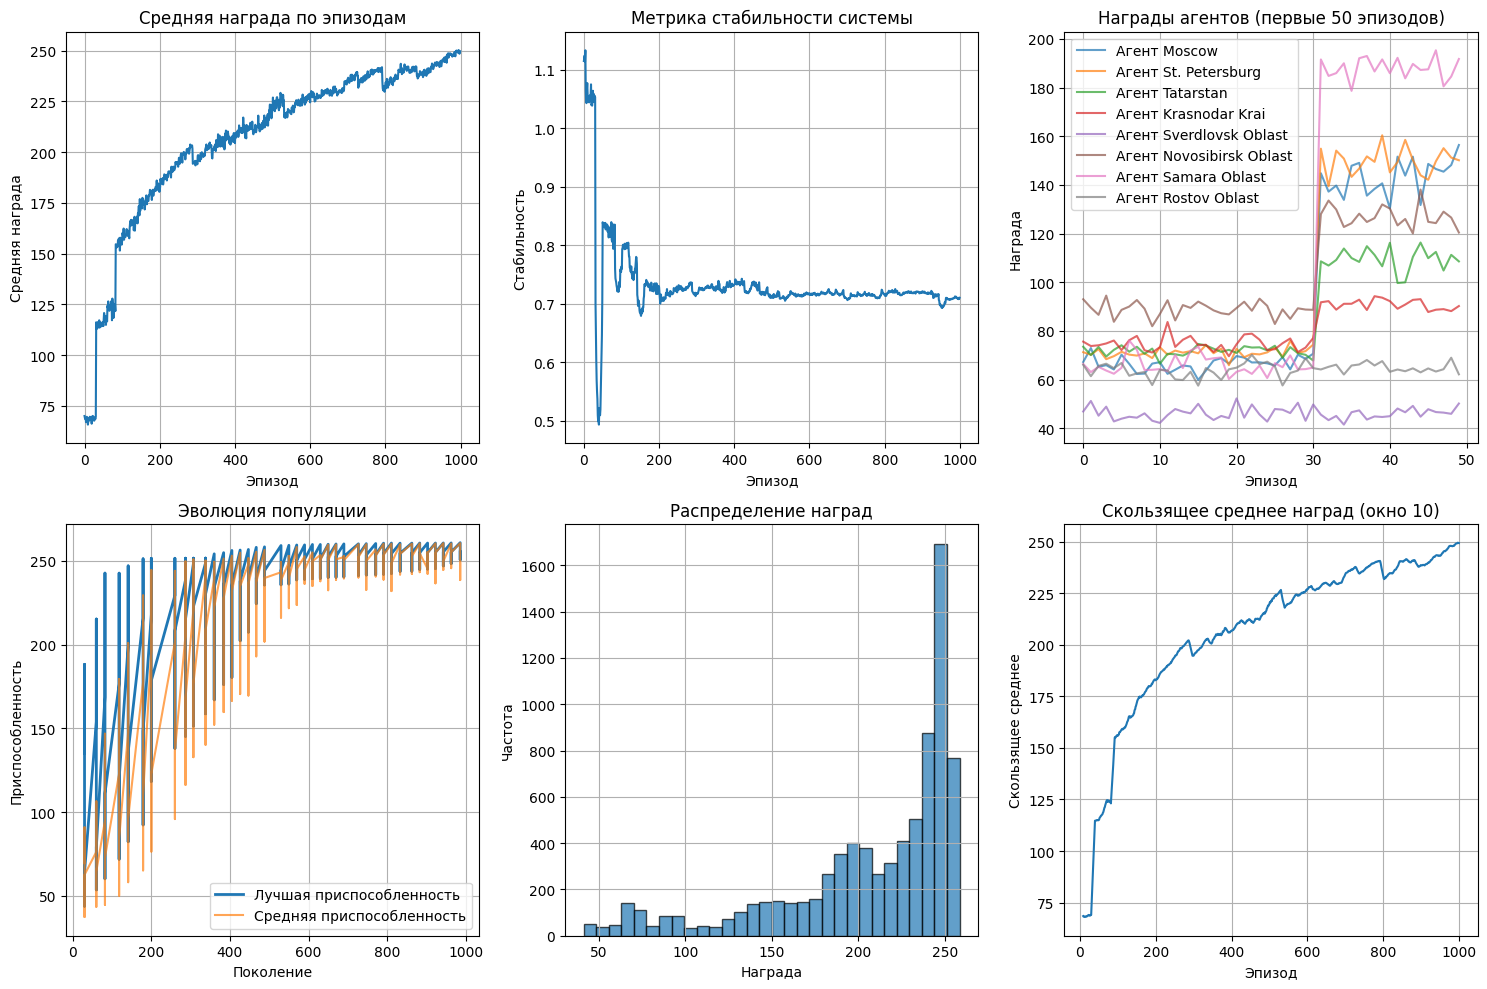

Результаты сохранены в maddpg-evo_results_20250911_110128.csv
=== Эксперимент MADDPG-EVO завершен ===

--- ЭКСПЕРИМЕНТ 3: MADDPG-EVO-DGM ---
=== Запуск эксперимента: MADDPG-EVO-DGM ===
Используемое устройство: cpu
Начало обучения на 1000 эпизодах...
MADDPG-EVO-DGM - Эпизод 0, средняя награда: 61.586, стабильность: 1.166
MADDPG-EVO-DGM - Адаптивная эволюционная оптимизация на эпизоде 20 (замедление прогресса)
MADDPG-EVO-DGM - Эпизод 20, средняя награда: 62.414, стабильность: 1.082
MADDPG-EVO-DGM - Эпизод 40, средняя награда: 118.904, стабильность: 0.775
MADDPG-EVO-DGM - Эпизод 60, средняя награда: 133.824, стабильность: 0.696
MADDPG-EVO-DGM - Эпизод 80, средняя награда: 145.978, стабильность: 0.710
MADDPG-EVO-DGM - Эпизод 100, средняя награда: 154.469, стабильность: 0.707
MADDPG-EVO-DGM - Эпизод 120, средняя награда: 166.287, стабильность: 0.719
MADDPG-EVO-DGM - Эпизод 140, средняя награда: 173.909, стабильность: 0.735
MADDPG-EVO-DGM - Эпизод 160, средняя награда: 181.357, стабильность:

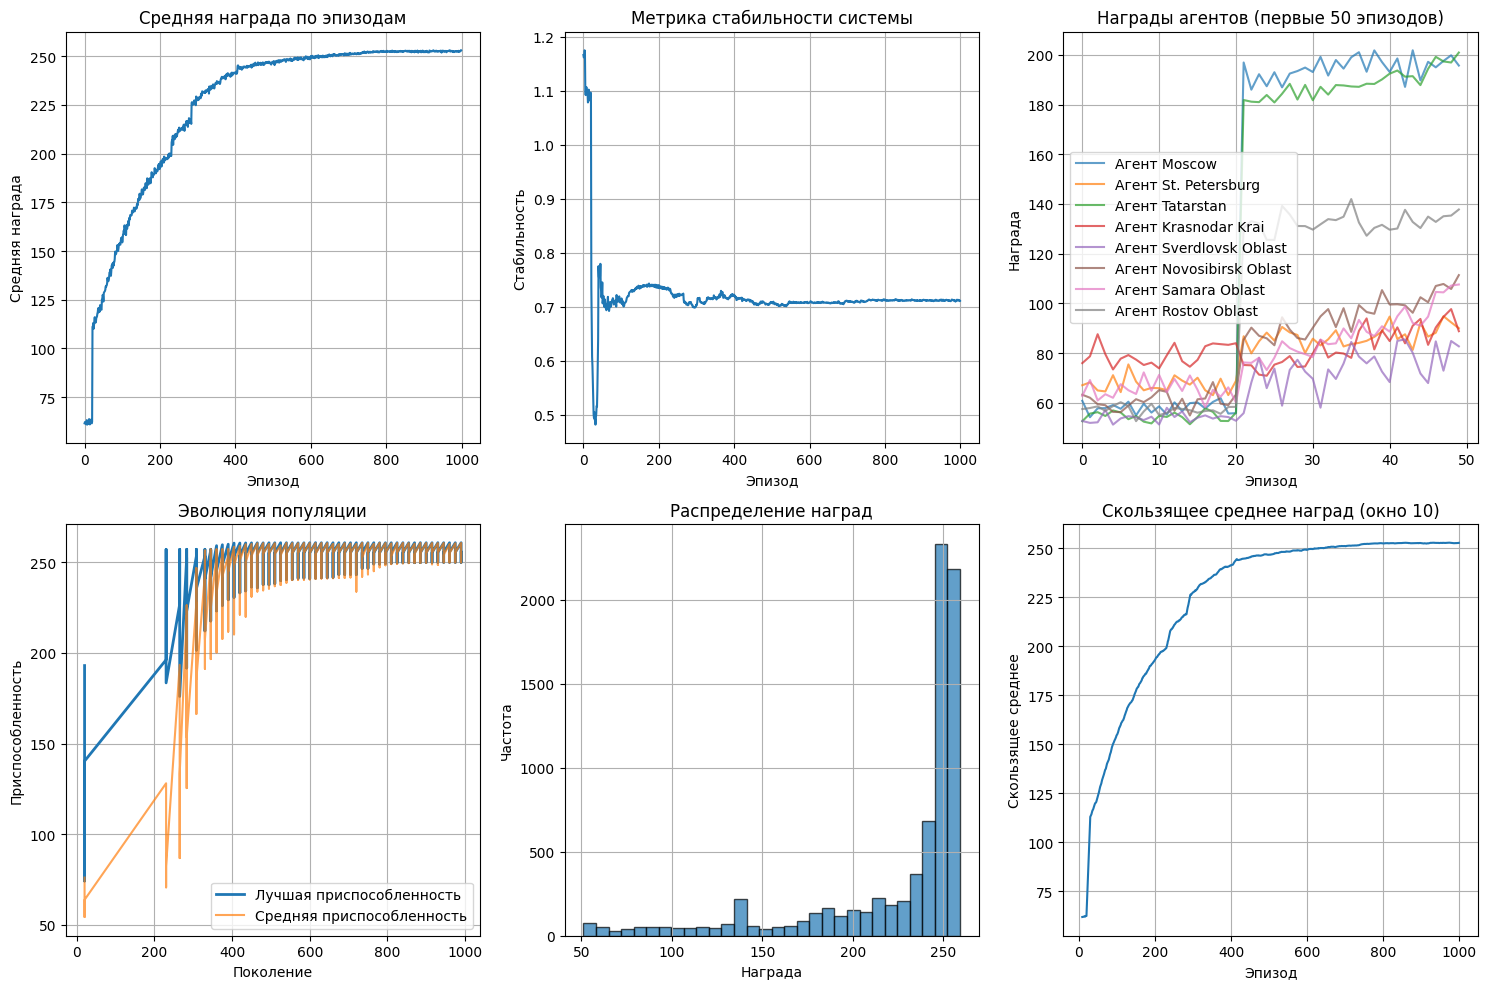

Результаты сохранены в maddpg-evo-dgm_results_20250911_121951.csv
=== Эксперимент MADDPG-EVO-DGM завершен ===

=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ВСЕХ ЭКСПЕРИМЕНТОВ ===


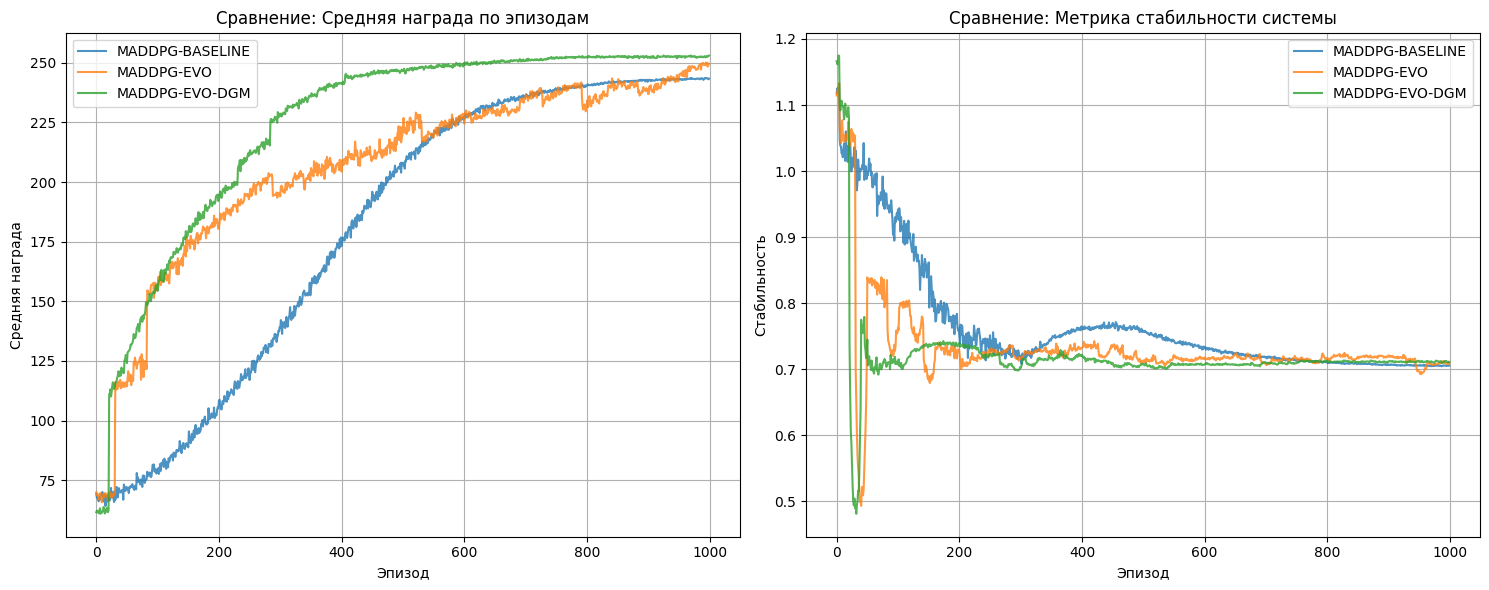


--- Таблица сравнения агрегированных метрик ---
                  Метрика  MADDPG-BASELINE  MADDPG-EVO  MADDPG-EVO-DGM  Разница (EVO - BASE)  Разница (DGM - BASE)
          Средняя награда         180.7376    206.3377        224.2435               25.6001               43.5060
     Максимальная награда         243.7199    250.1268        253.0780                6.4068                9.3581
     Средняя стабильность           0.7669      0.7326          0.7189               -0.0344               -0.0481
Максимальная стабильность           1.1322      1.1329          1.1749                0.0007                0.0428
---------------------------------------------
=== СРАВНЕНИЕ ВСЕХ ЭКСПЕРИМЕНТОВ ЗАВЕРШЕНО ===


In [24]:
# === БЛОК 12: Основной блок ===
if __name__ == "__main__":
    print("=== НАЧАЛО ЭКСПЕРИМЕНТОВ ===")
    # --- Подготовка данных и среды ---
    print("Загрузка и обработка реальных данных...")
    # ФАКТИЧЕСКИЕ ФАЙЛЫ
    data_processor = DemographicDataProcessor(
        'regions_data_selective.csv',  # путь к реальным данным
        'crisis.txt'  # путь к сценариям кризисов
    )
    # ИЗМЕНЕНО: Используем данные с 2000 года
    years = list(range(2000, 2025))
    target_regions = ['Moscow', 'St. Petersburg', 'Tatarstan', 'Krasnodar Krai',
                     'Sverdlovsk Oblast', 'Novosibirsk Oblast', 'Samara Oblast', 'Rostov Oblast']
    training_data = data_processor.generate_training_data(years, target_regions, apply_crisis=True)
    print(f"Обработано {len(training_data)} записей для {len(target_regions)} регионов")

    # --- ЭКСПЕРИМЕНТ 1: MADDPG-BASELINE ---
    print("\n--- ЭКСПЕРИМЕНТ 1: MADDPG-BASELINE ---")
    # Создаем новую среду для каждого эксперимента для независимости
    env_baseline = DemographicEnvironment(training_data.copy(), n_regions=8, max_steps=50)
    agents_maddpg_baseline, logger_maddpg_baseline = train_maddpg_baseline(
        env_baseline, n_episodes=1000, experiment_name="MADDPG-BASELINE"
    )
    print("=== Эксперимент MADDPG-BASELINE завершен ===")

    # --- ЭКСПЕРИМЕНТ 2: MADDPG-EVO ---
    print("\n--- ЭКСПЕРИМЕНТ 2: MADDPG-EVO ---")
    # Создаем новую среду для каждого эксперимента для независимости
    env_evo = DemographicEnvironment(training_data.copy(), n_regions=8, max_steps=50)
    agents_maddpg_evo, logger_maddpg_evo = train_maddpg_with_evolution(
        env_evo, n_episodes=1000, min_improvement=0.1, population_size=16, experiment_name="MADDPG-EVO"
    )
    print("=== Эксперимент MADDPG-EVO завершен ===")

    # --- ЭКСПЕРИМЕНТ 3: MADDPG-EVO-DGM ---
    print("\n--- ЭКСПЕРИМЕНТ 3: MADDPG-EVO-DGM ---")
    env_dgm = DemographicEnvironment(training_data.copy(), n_regions=8, max_steps=50)
    agents_maddpg_evo_dgm, logger_maddpg_evo_dgm = train_maddpg_with_evolution_dgm(
        env_dgm, n_episodes=1000, min_improvement=0.1, initial_population_size=16, experiment_name="MADDPG-EVO-DGM"
    )
    print("=== Эксперимент MADDPG-EVO-DGM завершен ===")

    # --- БЛОК 13: СРАВНЕНИЕ РЕЗУЛЬТАТОВ ---
    print("\n=== СРАВНЕНИЕ РЕЗУЛЬТАТОВ ВСЕХ ЭКСПЕРИМЕНТОВ ===")

    # Извлечение данных из логгеров
    # --- MADDPG-BASELINE ---
    baseline_episodes = np.array(logger_maddpg_baseline.metrics['episode'])
    baseline_avg_rewards = np.array(logger_maddpg_baseline.metrics['avg_reward'])
    baseline_stability = np.array(logger_maddpg_baseline.metrics['stability'])

    # --- MADDPG-EVO ---
    evo_episodes = np.array(logger_maddpg_evo.metrics['episode'])
    evo_avg_rewards = np.array(logger_maddpg_evo.metrics['avg_reward'])
    evo_stability = np.array(logger_maddpg_evo.metrics['stability'])

    # --- MADDPG-EVO-DGM ---
    dgm_episodes = np.array(logger_maddpg_evo_dgm.metrics['episode'])
    dgm_avg_rewards = np.array(logger_maddpg_evo_dgm.metrics['avg_reward'])
    dgm_stability = np.array(logger_maddpg_evo_dgm.metrics['stability'])

    # --- Построение сравнительных графиков ---
    plt.figure(figsize=(15, 6))

    # График 1: Сравнение средней награды
    plt.subplot(1, 2, 1)
    plt.plot(baseline_episodes, baseline_avg_rewards, label='MADDPG-BASELINE', alpha=0.8)
    plt.plot(evo_episodes, evo_avg_rewards, label='MADDPG-EVO', alpha=0.8)
    plt.plot(dgm_episodes, dgm_avg_rewards, label='MADDPG-EVO-DGM', alpha=0.8)
    plt.title('Сравнение: Средняя награда по эпизодам')
    plt.xlabel('Эпизод')
    plt.ylabel('Средняя награда')
    plt.legend()
    plt.grid(True)

    # График 2: Сравнение метрики стабильности
    plt.subplot(1, 2, 2)
    plt.plot(baseline_episodes, baseline_stability, label='MADDPG-BASELINE', alpha=0.8)
    plt.plot(evo_episodes, evo_stability, label='MADDPG-EVO', alpha=0.8)
    plt.plot(dgm_episodes, dgm_stability, label='MADDPG-EVO-DGM', alpha=0.8)
    plt.title('Сравнение: Метрика стабильности системы')
    plt.xlabel('Эпизод')
    plt.ylabel('Стабильность')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # --- Расчет агрегированных метрик ---
    # Определим общую длину для сравнения (минимальная длина среди всех)
    min_length = min(len(baseline_avg_rewards), len(evo_avg_rewards), len(dgm_avg_rewards))
    if min_length == 0:
        print("Ошибка: Недостаточно данных для сравнения.")
    else:
        # Метрики для MADDPG-BASELINE
        baseline_metrics_summary = {
            'Средняя награда': np.mean(baseline_avg_rewards[-min_length:]),
            'Максимальная награда': np.max(baseline_avg_rewards),
            'Средняя стабильность': np.mean(baseline_stability[-min_length:]),
            'Максимальная стабильность': np.max(baseline_stability)
        }

        # Метрики для MADDPG-EVO
        evo_metrics_summary = {
            'Средняя награда': np.mean(evo_avg_rewards[-min_length:]),
            'Максимальная награда': np.max(evo_avg_rewards),
            'Средняя стабильность': np.mean(evo_stability[-min_length:]),
            'Максимальная стабильность': np.max(evo_stability)
        }

        # Метрики для MADDPG-EVO-DGM
        dgm_metrics_summary = {
            'Средняя награда': np.mean(dgm_avg_rewards[-min_length:]),
            'Максимальная награда': np.max(dgm_avg_rewards),
            'Средняя стабильность': np.mean(dgm_stability[-min_length:]),
            'Максимальная стабильность': np.max(dgm_stability)
        }

        # --- Создание и вывод таблицы сравнения ---
        import pandas as pd

        # Формирование DataFrame для таблицы
        comparison_data = {
            'Метрика': list(baseline_metrics_summary.keys()),
            'MADDPG-BASELINE': list(baseline_metrics_summary.values()),
            'MADDPG-EVO': list(evo_metrics_summary.values()),
            'MADDPG-EVO-DGM': list(dgm_metrics_summary.values())
        }
        comparison_df = pd.DataFrame(comparison_data)

        # Расчет разницы относительно BASELINE
        comparison_df['Разница (EVO - BASE)'] = comparison_df['MADDPG-EVO'] - comparison_df['MADDPG-BASELINE']
        comparison_df['Разница (DGM - BASE)'] = comparison_df['MADDPG-EVO-DGM'] - comparison_df['MADDPG-BASELINE']

        # Форматирование для лучшего отображения
        pd.options.display.float_format = '{:.4f}'.format

        print("\n--- Таблица сравнения агрегированных метрик ---")
        print(comparison_df.to_string(index=False))
        print("---------------------------------------------")

    print("=== СРАВНЕНИЕ ВСЕХ ЭКСПЕРИМЕНТОВ ЗАВЕРШЕНО ===")
